# Survival function with censored data

In this notebook we will explore how not dealing with censored data correctly can lead to bias (in this example, a systematic underestimation of the expected lifetime).

In order to do this, consider the ages of 100 vampires who were "born" (i.e. turned into a vampire) between the years 1400 and 2018.

## Terminology

- _born_: in this context we will mean "turned into a vampire"
- _undead_: the state of being "alive" as a vampire, so after they were turned, but before they were permanently killed
- _died_: for a vampire, we mean that they were killed permanently, e.g. by exposure to sun rays, burning, stake to the heart, or any other way a vampire can die
- _age_: the number of years since a vampire was turned
- _lifetime_ or _age at time of death_: the age a vampire had when they died
- _censored lifetime_: this can be their age at time of death if they have already died, but if they are still undead, it is their current age

In [1]:
import numpy as np
import lifelines

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
start_year = 1400
current_year = 2018
number_of_vampires = 100

## We have more data from vampires born recently

This can be because of a population increase, or because data collection has improved.

In [3]:
birth_dates_increasing = map(int, np.random.triangular(
    start_year, current_year, current_year, size=number_of_vampires))

Text(0,0.5,'frequency')

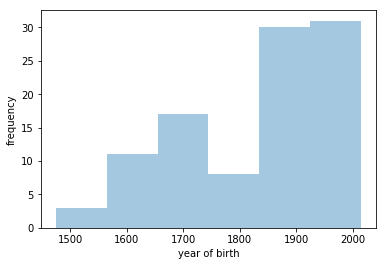

In [4]:
sns.distplot(birth_dates_increasing, kde=False, label='histogram of vampires born in each year')
plt.xlabel('year of birth')
plt.ylabel('frequency')

## We know all their ages at time of death - even if they haven't died yet (asked a clairvoyant)

In [5]:
# Their theoretical average age is 500 years
# this is the mean of the distribution we will draw their final ages from
theoretical_average_age = 500

true_ages_at_time_of_death = map(int, np.random.exponential(
    theoretical_average_age, size=number_of_vampires))

Text(0,0.5,'frequency')

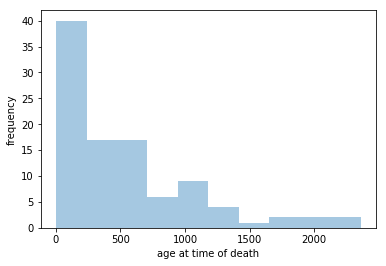

In [6]:
sns.distplot(true_ages_at_time_of_death, kde=False)
plt.xlabel('age at time of death')
plt.ylabel('frequency')

## Censored data has a different distribution from the actual lifetimes

If the year a vampire will die lies in the future (currently meaning after 2018), we could not know without asking a clairvoyant how old the vampire will be when they die. We only know they will be _at least_ the age they are now. We will therefore use their current age, and record the fact that their age at time of death is _censored_.

In [7]:
def year_of_death(year_of_birth, age_at_time_of_death):
    return year_of_birth + age_at_time_of_death

def censored_age(birth_year, age_at_time_of_death):
    death_year = year_of_death(birth_year, age_at_time_of_death)
    
    return (age_at_time_of_death if (death_year <= 2018)
            else (2018 - birth_year))

In [8]:
# Having a set of data from each vampire: birth year and age at time of death, we know what the
# year is in which they die. If this year lies in the future, we know we could not have observed it
# without a clairvoyant, so we replace the age with their current age.
ages_with_censoring = map(lambda x: censored_age(x[0], x[1]),
                    zip(birth_dates_increasing, true_ages_at_time_of_death))

# We mark an age as 'observed' if the age with censoring is equal to the true age at time of death
# 'observed' is exactly the opposite of 'censored'
# (if a data point is observed, it is not censored, and vice versa)
observed = map(lambda x: x[0] == x[1], zip(ages_with_censoring, true_ages_at_time_of_death))

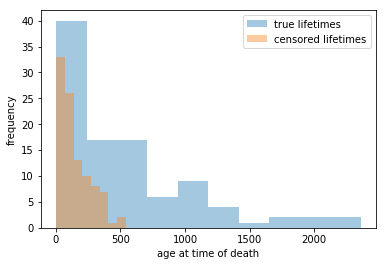

In [9]:
sns.distplot(true_ages_at_time_of_death, kde=False, label='true lifetimes')
sns.distplot(ages_with_censoring, kde=False, label='censored lifetimes')
plt.xlabel('age at time of death')
plt.ylabel('frequency')
plt.legend();

We can see that the distribution of censored lifetimes differs significantly from the true distribution (which one would only know if they could look into the future). We can compare the two distributions by drawing survival curves.


In [10]:
km = lifelines.KaplanMeierFitter()

Text(0.5,0,'age (years)')

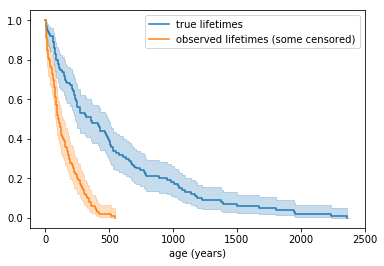

In [12]:
km.fit(true_ages_at_time_of_death, np.ones(number_of_vampires), label='true lifetimes')
ax = km.plot()

km.fit(ages_with_censoring, np.ones(number_of_vampires), label='observed lifetimes (some censored)')
plot = km.plot(ax=ax)

plot.set_xlabel('age (years)')


## Removing all censored data doesn't help!

What if we simply remove all data points of vampires that are still undead? Then the distribution of all lifetimes should match the actual distribution obtained using Alice's predictions much better, right? Wrong!

We plot the two survival curves we saw before, but now we add a third: only including the final ages for those vampires that have died already. Can you think of a reason why this doesn't make the problem of skewing the distribution towards lower lifetimes any better?

In [13]:
ages_with_censoring_observed = [age for i, age in enumerate(ages_with_censoring) if observed[i]]

Text(0.5,0,'age (years)')

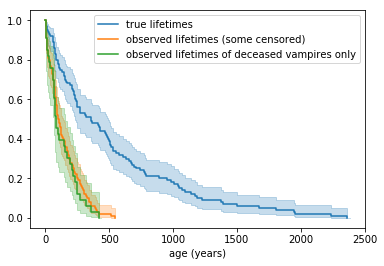

In [15]:
km.fit(true_ages_at_time_of_death, np.ones(number_of_vampires), label='true lifetimes')
ax = km.plot()

km.fit(ages_with_censoring, np.ones(number_of_vampires), label='observed lifetimes (some censored)')
ax2 = km.plot(ax=ax)

km.fit(ages_with_censoring_observed, np.ones_like(ages_with_censoring_observed), label='observed lifetimes of deceased vampires only')
plot = km.plot(ax=ax2)

plot.set_xlabel('age (years)')

## Kaplan Meier estimate uses information of censored data

Text(0.5,0,'age (years)')

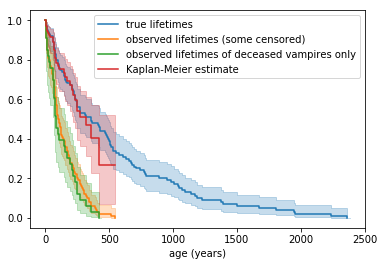

In [17]:
km.fit(true_ages_at_time_of_death, np.ones(number_of_vampires), label='true lifetimes')
ax = km.plot()

km.fit(ages_with_censoring, np.ones(number_of_vampires), label='observed lifetimes (some censored)')
ax2 = km.plot(ax=ax)

km.fit(ages_with_censoring_observed, np.ones_like(ages_with_censoring_observed), label='observed lifetimes of deceased vampires only')
ax3 = km.plot(ax=ax2)

km.fit(ages_with_censoring, observed, label='Kaplan-Meier estimate')
plot = km.plot(ax=ax3)

plot.set_xlabel('age (years)')